# ETS models

The ETS models are a family of time series models with an underlying state space model consisting of a level component, a trend component (T), a seasonal component (S), and an error term (E).

This notebook shows how they can be used with `statsmodels`. For a more thorough treatment we refer to [1], chapter 8 (free online resource), on which the implementation in statsmodels and the examples used in this notebook are based.

`statsmodels` implements all combinations of:
- additive and multiplicative error model
- additive and multiplicative trend, possibly dampened
- additive and multiplicative seasonality

However, not all of these methods are stable. Refer to [1] and references therein for more info about model stability.

[1] Hyndman, Rob J., and Athanasopoulos, George. *Forecasting: principles and practice*, 3rd edition, OTexts, 2021. https://otexts.com/fpp3/expsmooth.html

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Simple exponential smoothing

The simplest of the ETS models is also known as *simple exponential smoothing*. In ETS terms, it corresponds to the (A, N, N) model, that is, a model with additive errors, no trend, and no seasonality. The state space formulation of Holt's method is:

\begin{align}
y_{t} &= y_{t-1} + e_t\\
l_{t} &= l_{t-1} + \alpha e_t\\
\end{align}

This state space formulation can be turned into a different formulation, a forecast and a smoothing equation (as can be done with all ETS models):

\begin{align}
\hat{y}_{t|t-1} &= l_{t-1}\\
l_{t} &= \alpha y_{t-1} + (1 - \alpha) l_{t-1}
\end{align}

Here, $\hat{y}_{t|t-1}$ is the forecast/expectation of $y_t$ given the information of the previous step. In the simple exponential smoothing model, the forecast corresponds to the previous level. The second equation (smoothing equation) calculates the next level as weighted average of the previous level and the previous observation.

Text(0, 0.5, 'Annual oil production in Saudi Arabia (Mt)')

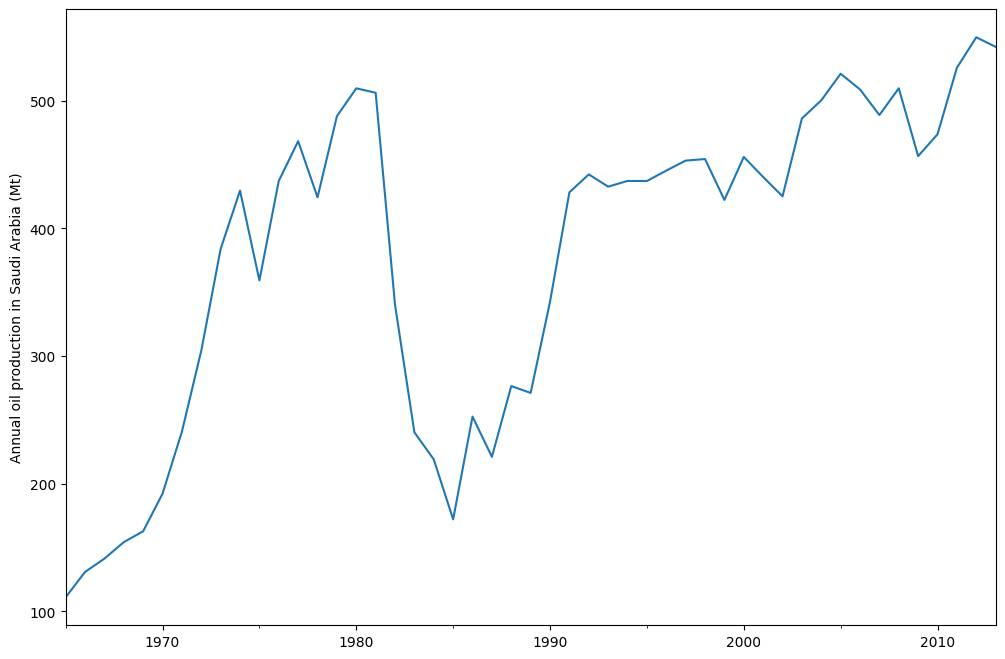

In [3]:
oildata = [
    111.0091,
    130.8284,
    141.2871,
    154.2278,
    162.7409,
    192.1665,
    240.7997,
    304.2174,
    384.0046,
    429.6622,
    359.3169,
    437.2519,
    468.4008,
    424.4353,
    487.9794,
    509.8284,
    506.3473,
    340.1842,
    240.2589,
    219.0328,
    172.0747,
    252.5901,
    221.0711,
    276.5188,
    271.1480,
    342.6186,
    428.3558,
    442.3946,
    432.7851,
    437.2497,
    437.2092,
    445.3641,
    453.1950,
    454.4096,
    422.3789,
    456.0371,
    440.3866,
    425.1944,
    486.2052,
    500.4291,
    521.2759,
    508.9476,
    488.8889,
    509.8706,
    456.7229,
    473.8166,
    525.9509,
    549.8338,
    542.3405,
]
oil = pd.Series(oildata, index=pd.date_range("1965", "2013", freq="YS"))
oil.plot()
plt.ylabel("Annual oil production in Saudi Arabia (Mt)")

The plot above shows annual oil production in Saudi Arabia in million tonnes. The data are taken from the R package `fpp2` (companion package to prior version [1]).
Below you can see how to fit a simple exponential smoothing model using statsmodels's ETS implementation to this data. Additionally, the fit using `forecast` in R is shown as comparison.

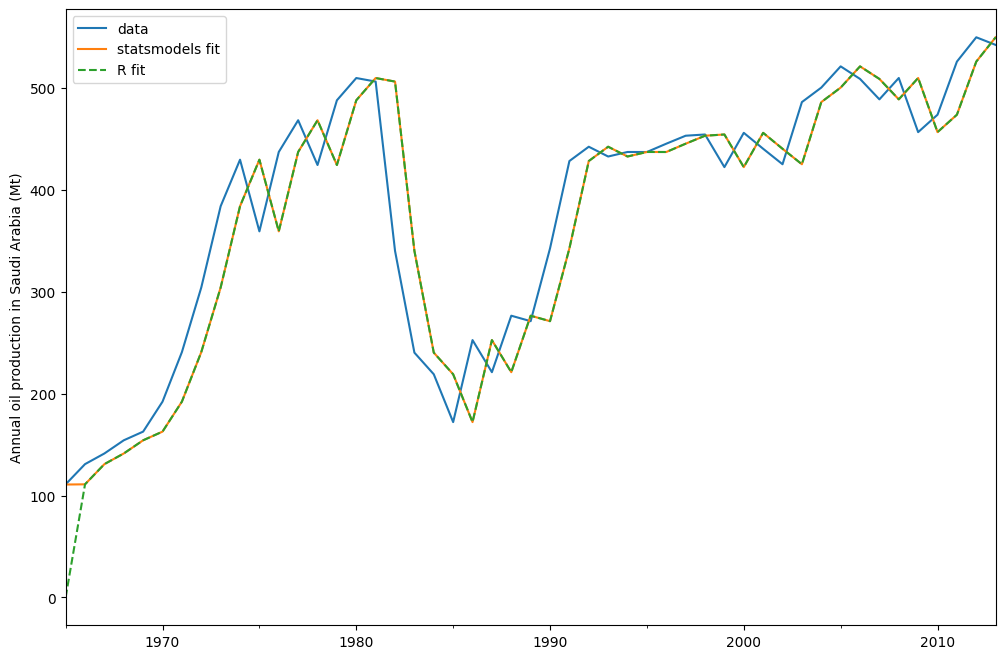

In [4]:
model = ETSModel(oil)
fit = model.fit(maxiter=10000)
oil.plot(label="data")
fit.fittedvalues.plot(label="statsmodels fit")
plt.ylabel("Annual oil production in Saudi Arabia (Mt)")

# obtained from R
params_R = [0.99989969, 0.11888177503085334, 0.80000197, 36.46466837, 34.72584983]
yhat = model.smooth(params_R).fittedvalues
yhat.plot(label="R fit", linestyle="--")

plt.legend()

By default the initial states are considered to be fitting parameters and are estimated by maximizing log-likelihood. It is possible to only use a heuristic for the initial values:

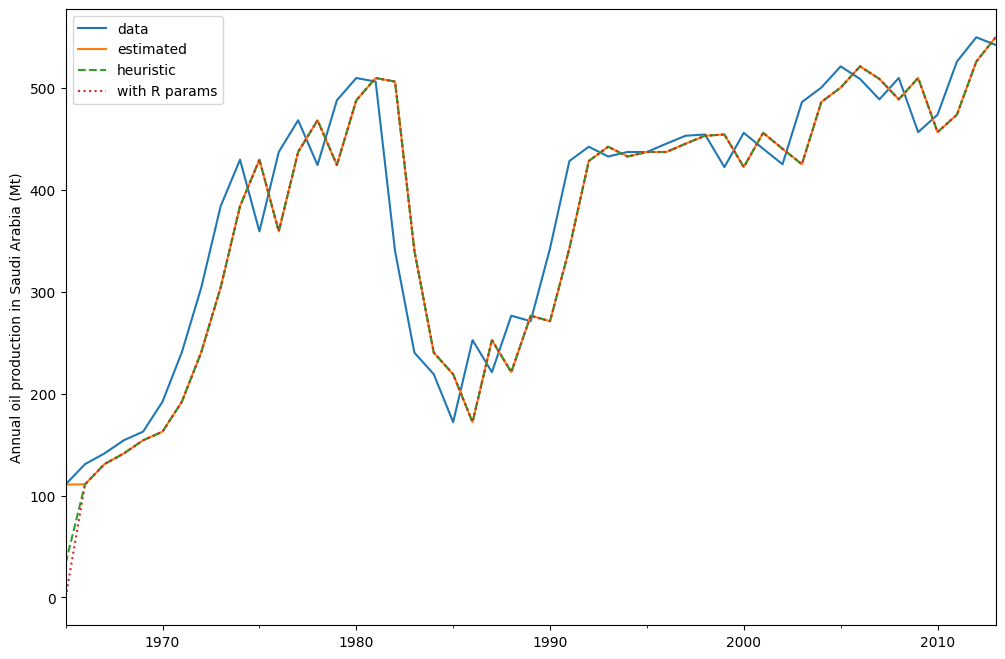

In [5]:
model_heuristic = ETSModel(oil, initialization_method="heuristic")
fit_heuristic = model_heuristic.fit()
oil.plot(label="data")
fit.fittedvalues.plot(label="estimated")
fit_heuristic.fittedvalues.plot(label="heuristic", linestyle="--")
plt.ylabel("Annual oil production in Saudi Arabia (Mt)")

# obtained from R
params = [0.99989969, 0.11888177503085334, 0.80000197, 36.46466837, 34.72584983]
yhat = model.smooth(params).fittedvalues
yhat.plot(label="with R params", linestyle=":")

plt.legend()

The fitted parameters and some other measures are shown using `fit.summary()`. Here we can see that the log-likelihood of the model using fitted initial states is fractionally lower than the one using a heuristic for the initial states.

In [6]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   49
Model:                       ETS(ANN)   Log Likelihood                -259.257
Date:                Tue, 23 Dec 2025   AIC                            524.514
Time:                        18:21:47   BIC                            530.189
Sample:                    01-01-1965   HQIC                           526.667
                         - 01-01-2013   Scale                         2307.767
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.132      7.551      0.000       0.740       1.259
initial_level     110.7864     48.110      2.303      0.021      16.492     205.081
Ljung-Box (Q):                  

In [7]:
print(fit_heuristic.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   49
Model:                       ETS(ANN)   Log Likelihood                -260.521
Date:                Tue, 23 Dec 2025   AIC                            525.042
Time:                        18:21:47   BIC                            528.826
Sample:                    01-01-1965   HQIC                           526.477
                         - 01-01-2013   Scale                         2429.964
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.132      7.559      0.000       0.741       1.259
              initialization method: heuristic
----------------------------------------------
initial_level         

## Holt-Winters' seasonal method

The exponential smoothing method can be modified to incorporate a trend and a seasonal component. In the additive Holt-Winters' method, the seasonal component is added to the rest. This model corresponds to the ETS(A, A, A) model, and has the following state space formulation:

\begin{align}
y_t &= l_{t-1} + b_{t-1} + s_{t-m} + e_t\\
l_{t} &= l_{t-1} + b_{t-1} + \alpha e_t\\
b_{t} &= b_{t-1} + \beta e_t\\
s_{t} &= s_{t-m} + \gamma e_t
\end{align}



Text(0, 0.5, 'Australian Tourists')

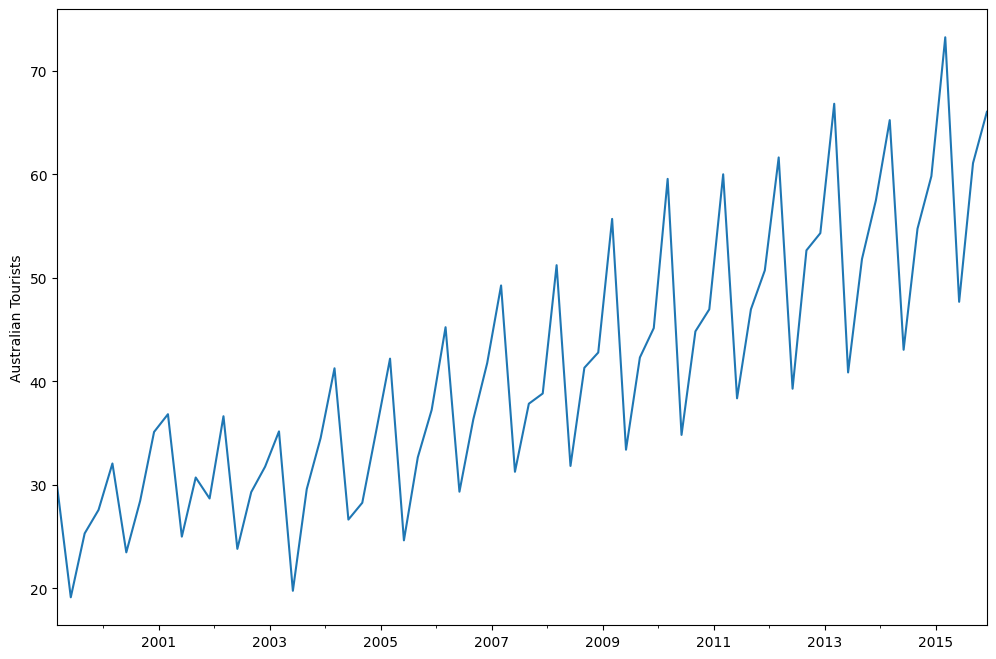

In [8]:
austourists_data = [
    30.05251300,
    19.14849600,
    25.31769200,
    27.59143700,
    32.07645600,
    23.48796100,
    28.47594000,
    35.12375300,
    36.83848500,
    25.00701700,
    30.72223000,
    28.69375900,
    36.64098600,
    23.82460900,
    29.31168300,
    31.77030900,
    35.17787700,
    19.77524400,
    29.60175000,
    34.53884200,
    41.27359900,
    26.65586200,
    28.27985900,
    35.19115300,
    42.20566386,
    24.64917133,
    32.66733514,
    37.25735401,
    45.24246027,
    29.35048127,
    36.34420728,
    41.78208136,
    49.27659843,
    31.27540139,
    37.85062549,
    38.83704413,
    51.23690034,
    31.83855162,
    41.32342126,
    42.79900337,
    55.70835836,
    33.40714492,
    42.31663797,
    45.15712257,
    59.57607996,
    34.83733016,
    44.84168072,
    46.97124960,
    60.01903094,
    38.37117851,
    46.97586413,
    50.73379646,
    61.64687319,
    39.29956937,
    52.67120908,
    54.33231689,
    66.83435838,
    40.87118847,
    51.82853579,
    57.49190993,
    65.25146985,
    43.06120822,
    54.76075713,
    59.83447494,
    73.25702747,
    47.69662373,
    61.09776802,
    66.05576122,
]
index = pd.date_range("1999-03-01", "2015-12-01", freq="3MS")
austourists = pd.Series(austourists_data, index=index)
austourists.plot()
plt.ylabel("Australian Tourists")

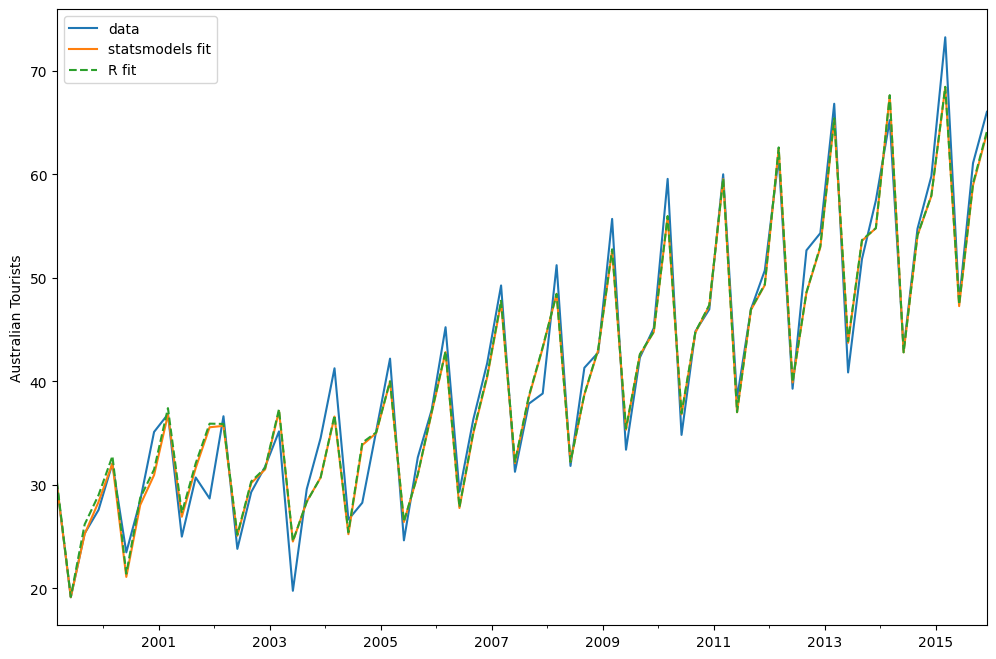

In [9]:
# fit in statsmodels
model = ETSModel(
    austourists,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=4,
)
fit = model.fit()

# fit with R params
params_R = [
    0.35445427,
    0.03200749,
    0.39993387,
    0.97999997,
    24.01278357,
    0.97770147,
    1.76951063,
    -0.50735902,
    -6.61171798,
    5.34956637,
]
fit_R = model.smooth(params_R)

austourists.plot(label="data")
plt.ylabel("Australian Tourists")

fit.fittedvalues.plot(label="statsmodels fit")
fit_R.fittedvalues.plot(label="R fit", linestyle="--")
plt.legend()

In [10]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   68
Model:                      ETS(AAdA)   Log Likelihood                -152.627
Date:                Tue, 23 Dec 2025   AIC                            327.254
Time:                        18:21:49   BIC                            351.668
Sample:                    03-01-1999   HQIC                           336.928
                         - 12-01-2015   Scale                            5.213
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.3398      0.111      3.070      0.002       0.123       0.557
smoothing_trend        0.0259      0.008      3.157      0.002       0.010       0.042
smoothing_seasonal  

## Predictions

The ETS model can also be used for predicting. There are several different methods available:
- `forecast`: makes out of sample predictions
- `predict`: in sample and out of sample predictions
- `simulate`: runs simulations of the statespace model
- `get_prediction`: in sample and out of sample predictions, as well as prediction intervals

We can use them on our previously fitted model to predict from 2014 to 2020.

In [11]:
pred = fit.get_prediction(start="2014", end="2020")

In [12]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2014-03-01,67.611027,63.136055,72.085999
2014-06-01,42.814635,38.339664,47.289607
2014-09-01,54.106451,49.631480,58.581423
2014-12-01,57.928390,53.453418,62.403361
2015-03-01,68.421956,63.946984,72.896928
2015-06-01,47.277638,42.802666,51.752610
2015-09-01,58.954630,54.479658,63.429602
2015-12-01,63.982153,59.507182,68.457125
2016-03-01,75.905250,71.430278,80.380221
2016-06-01,51.417904,46.653827,56.181980


In this case the prediction intervals were calculated using an analytical formula. This is not available for all models. For these other models, prediction intervals are calculated by performing multiple simulations (1000 by default) and using the percentiles of the simulation results. This is done internally by the `get_prediction` method.

We can also manually run simulations, e.g. to plot them. Since the data ranges until end of 2015, we have to simulate from the first quarter of 2016 to the first quarter of 2020, which means 17 steps.

In [13]:
simulated = fit.simulate(anchor="end", nsimulations=17, repetitions=100)

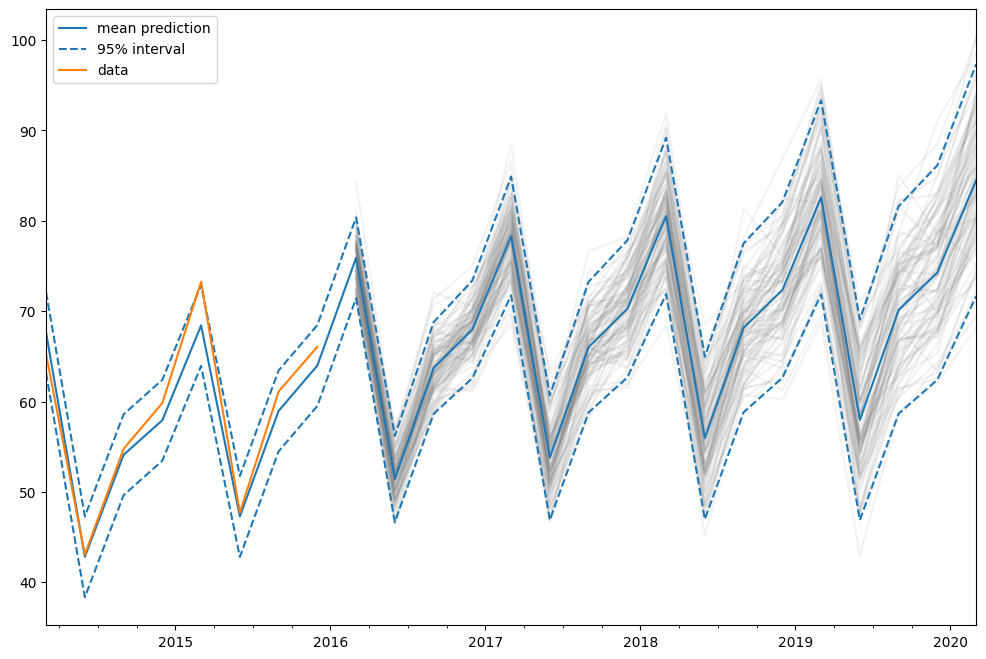

In [14]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()

In this case, we chose "end" as simulation anchor, which means that the first simulated value will be the first out of sample value. It is also possible to choose other anchor inside the sample.